## current workload: e12_e14_GSE178546.csv

Please see the [Network analysis with Seurat data](https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/04_Network_analysis/Network_analysis_with_Seurat_data.ipynb) notebook for a walkthrough about how to handle SeuratObject after converting to AnnData. 

In [11]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [12]:
import celloracle as co
from celloracle import motif_analysis as ma
co.__version__

'0.16.0'

In [57]:
import plotly.express as px

ModuleNotFoundError: No module named 'plotly'

In [13]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [14]:
save_folder = "co_output/figures/e12_e14_GSE178546"
os.makedirs(save_folder, exist_ok=True)

Load data:
- adata warning: already log-transformed occurs regardless of which layer is transformed. This is an [unresolved scanpy issue](https://github.com/scverse/scanpy/issues/1333).
- scRNA data must be in anndata format. 
    - please note that while [celloracle](https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/04_Network_analysis/Network_analysis_with_Paul_etal_2015_data.ipynb) recommends downsampling datasets with >20k cells, downsampling was heavily cautioned against by our prof (in STAT540)
    - `Cell number` >30 000 known to cause issues downstream!
    - `Gene number` >3000 known to cause issues downstream!!
- note: skipped (Optional) Add TF-target gene pair manually because we don't have this data 

As of Feb 2024, both ATAC and RNA analyses are within the same SeuratObject. After RNA_preprocessing: 

`preprocessed_rna_combined_e12_e14_GSE178546.h5ad`: Current assay is RNA. Gene IDs are expected in `adata.var_names` (e.g. Zfhx4)

`atac_combined_e12_e14_GSE178546.h5ad`: Current assay is ATAC. Peak IDs are expected in `adata.var_names` (e.g. chr1-3412861-3413118).


In [15]:
input_file = './co_input/preprocessed_rna_combined_e12_e14_GSE178546.h5ad'
adata = sc.read_h5ad(input_file) # just preprocessed!

print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")  

Cell number is :5471
Gene number is :2999


In [16]:
adata.layers

Layers with keys: logcounts, raw_count

In [17]:
# Check data in anndata
# print("Metadata columns :", list(adata.obs.columns))
# print("Dimensional reduction: ", list(adata.obsm.keys()))
print(adata)

AnnData object with n_obs × n_vars = 5471 × 2999
    obs: 'orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'nucleosome_group', 'TSS.enrichment', 'TSS.percentile', 'high.tss', 'fragments', 'FRiP', 'blacklist_fraction', 'peak_region_fragments', 'pct_reads_in_peaks', 'dataset', 'ATAC_snn_res.1.2', 'seurat_clusters', 'ATAC_snn_res.0.8', 'ATAC_snn_res.0.6', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.31', 'prediction.score.46', 'prediction.score.9', 'prediction.score.40', 'prediction.score.1', 'prediction.score.12', 'prediction.score.27', 'prediction.score.18', 'prediction.score.30', 'prediction.score.11', 'prediction.score.2', 'prediction.score.15', 'prediction.score.6', 'prediction.score.22', 'prediction.score.29', 'prediction.score.43', 'prediction.score.19', 'prediction.score.4', 'prediction.score.24', 'prediction.score.21', 'prediction.score.8', 'prediction.score.13', 'prediction.score.35', 'prediction.score.42', 'predictio

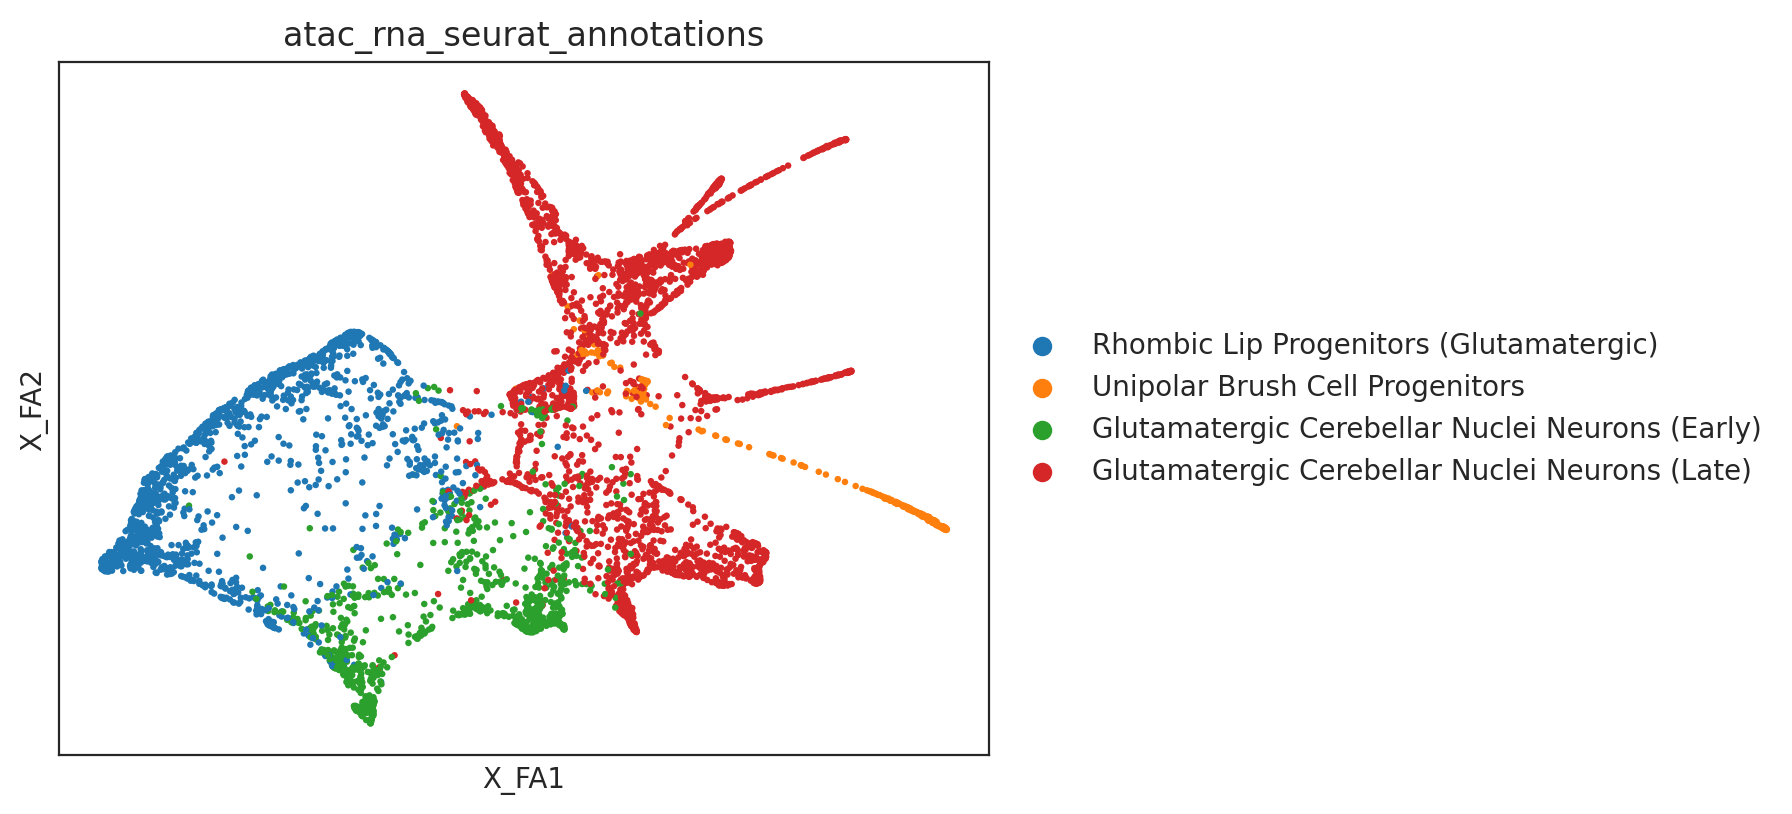

In [18]:
# to solve keyerror issue with importing https://github.com/morris-lab/CellOracle/issues/53#issuecomment-872999129
sc.pl.embedding(adata, basis="X_draw_graph_fa", color="atac_rna_seurat_annotations")
# print(adata)

In [19]:
oracle = co.Oracle()

Manually set the metadata column with annotated cell types, and dimensional reduction with the appropriate embedding. 

In [20]:
# In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
adata.X = adata.layers["raw_count"].copy()

In [21]:
adata.X.min() < 0

False

In [22]:
# Instantiate Oracle object.
# cluster_column_name are the annotated cell types
# embedding_name are the dimension reduction used
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="atac_rna_seurat_annotations",
                                   embedding_name="X_draw_graph_fa")

In [23]:
# 'Xkr4' in oracle.adata.var_names
oracle.adata.var_names

Index(['Hnf4g', 'Zfhx4', 'Stmn2', 'Pmp2', 'RP24-137C19.6', 'Chmp4c', 'Ralyl',
       'Lrrcc1', 'Car3', 'Car2',
       ...
       'Elovl3', 'Ina', 'Dusp5', 'Nutf2-ps1', 'Tectb', 'Nrap', 'Plekhs1',
       'Afap1l2', 'Hspa12a', 'Csf2ra'],
      dtype='object', length=2999)

In [24]:
oracle.import_TF_data(TF_info_matrix_path="./co_input/base_GRN_dataframe_e12_e14_GSE178546.parquet")

KNN imputation: same method as [velocyto for visualizing cell transitions](https://github.com/velocyto-team/velocyto-notebooks/blob/master/python/hgForebrainGlutamatergic.ipynb).

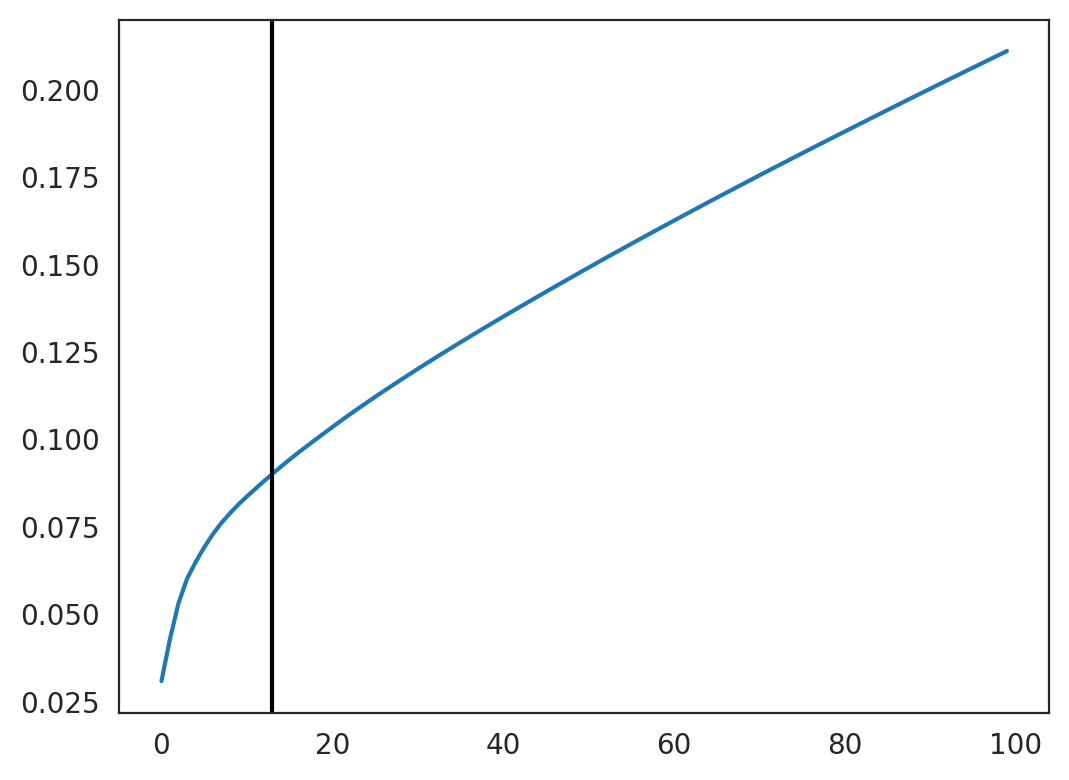

13


In [25]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [26]:
# Estimate the optimal number of nearest neighbors for KNN imputation.
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :5471


In [27]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :136


In [28]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

saving and loading

In [29]:
# Save oracle object.
oracle.to_hdf5("./co_output/e12_e14_GSE178546.celloracle.oracle")

In [30]:
# Load file.
oracle = co.load_hdf5("./co_output/e12_e14_GSE178546.celloracle.oracle")

GRN calculations
- for a review on scanpy tl and pl, [see example at the bottom](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.draw_graph.html)

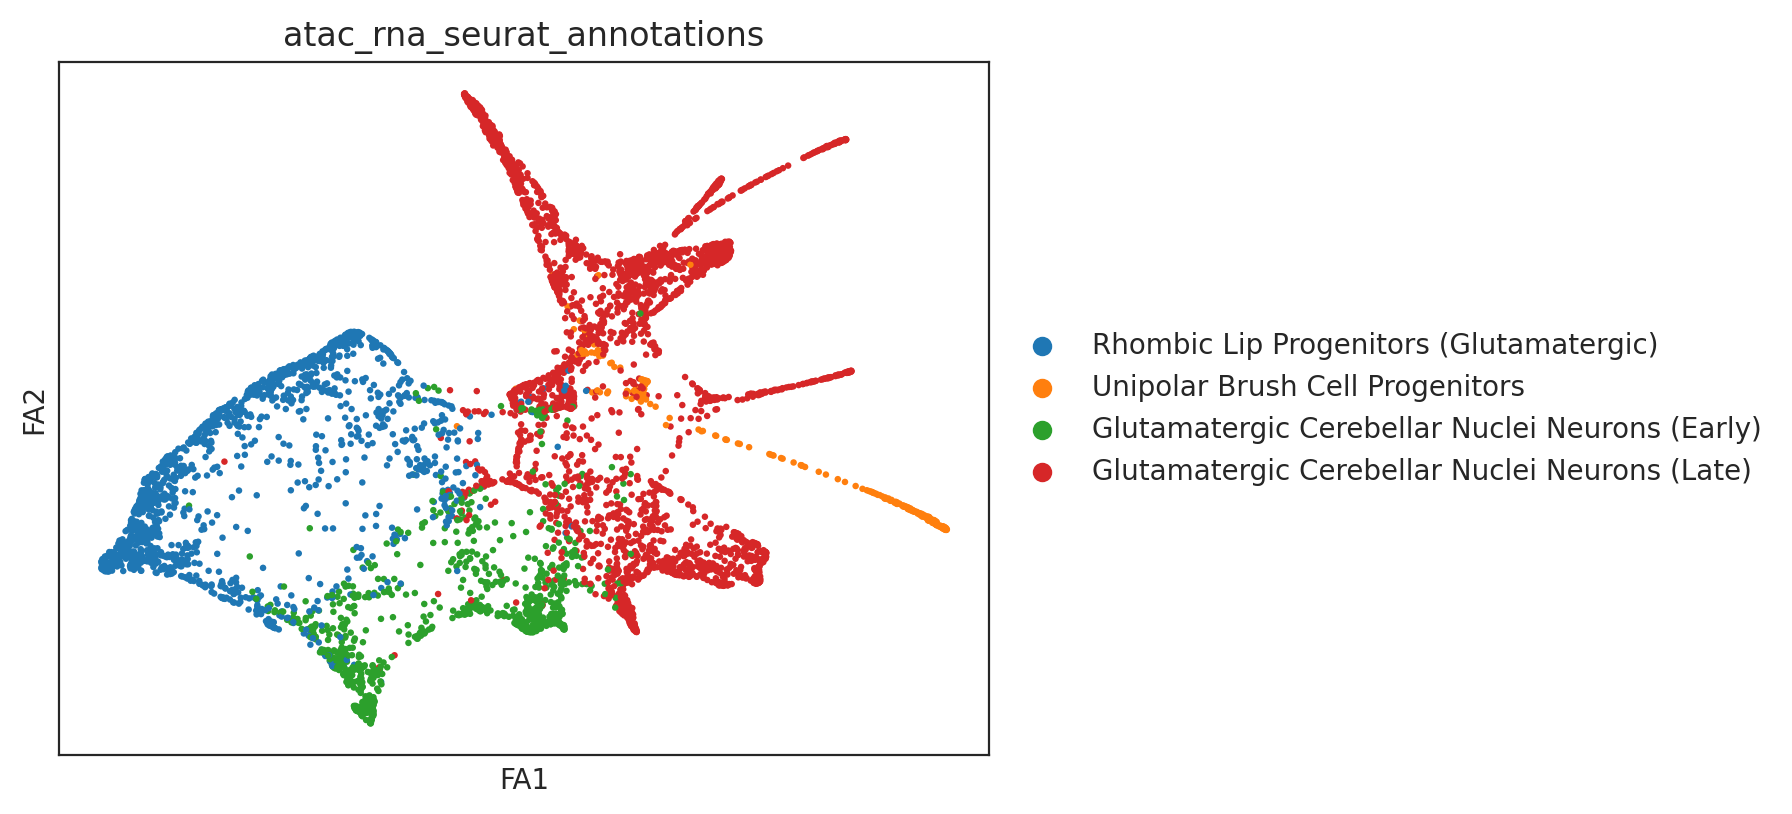

In [31]:
# Check clustering data
sc.pl.draw_graph(oracle.adata, color="atac_rna_seurat_annotations")  # colour should match chosen `cluster_column_name`

# debugging: 22 feb 2023


In [32]:
%%time
# Calculate GRN for each population in clustering unit.
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit="atac_rna_seurat_annotations", alpha=10,
                         verbose_level=10)

  0%|          | 0/4 [00:00<?, ?it/s]

Inferring GRN for Glutamatergic Cerebellar Nuclei Neurons (Early)...


  0%|          | 0/1929 [00:00<?, ?it/s]

Inferring GRN for Glutamatergic Cerebellar Nuclei Neurons (Late)...


  0%|          | 0/1929 [00:00<?, ?it/s]

Inferring GRN for Rhombic Lip Progenitors (Glutamatergic)...


  0%|          | 0/1929 [00:00<?, ?it/s]

Inferring GRN for Unipolar Brush Cell Progenitors...


  0%|          | 0/1929 [00:00<?, ?it/s]

CPU times: user 9min 7s, sys: 1.92 s, total: 9min 9s
Wall time: 9min 18s


(Optional) Export GRNs (raw GRN data is stored as a dictionary of dataframe in the `links_dict` attribute)
- For example, you can get the GRN for the "Unipolar brush cells" cluster with the following commands.

In [33]:
links.links_dict.keys()

dict_keys(['Glutamatergic Cerebellar Nuclei Neurons (Early)', 'Glutamatergic Cerebellar Nuclei Neurons (Late)', 'Rhombic Lip Progenitors (Glutamatergic)', 'Unipolar Brush Cell Progenitors'])

In [34]:
links.links_dict["Unipolar Brush Cell Progenitors"]

,source,target,coef_mean,coef_abs,p,-logp
0,Foxn4,0610040J01Rik,-0.010505,0.010505,3.587646e-06,5.445190
1,Hes5,0610040J01Rik,0.013661,0.013661,6.022288e-05,4.220238
2,Crx,0610040J01Rik,-0.014851,0.014851,9.144367e-10,9.038846
3,Heyl,0610040J01Rik,0.002336,0.002336,4.449496e-02,1.351689
4,Erf,0610040J01Rik,-0.000028,0.000028,9.881197e-01,0.005190
...,...,...,...,...,...,...
42143,Fli1,Zrsr1,0.009428,0.009428,5.065336e-11,10.295392
42144,Hsf3,Zrsr1,-0.000318,0.000318,6.468680e-01,0.189184
42145,Zic4,Zrsr1,-0.001614,0.001614,5.091165e-03,2.293183
42146,Fosl1,Zrsr1,0.007327,0.007327,9.514388e-10,9.021619


In [35]:
# Set cluster name
cluster = "Unipolar Brush Cell Progenitors"
# Save as csv
links.links_dict[cluster].to_csv(f"raw_GRN_for_{cluster}_e12_e14_GSE178546.csv")

(Optional) Changing both the cluster colors and order.
- `links` object stores color information in the palette attribute. This information is used when visualizing the clusters.

In [36]:
# Show the contents of pallete
links.palette

,palette
Rhombic Lip Progenitors (Glutamatergic),#1F77B4
Unipolar Brush Cell Progenitors,#FF7F0E
Glutamatergic Cerebellar Nuclei Neurons (Early),#2CA02C
Glutamatergic Cerebellar Nuclei Neurons (Late),#D62728


In [37]:
# where order is a new list of all cluster name variables in desired order
# order = [] 
# links.palette = links.palette.loc[order]
links.palette

# Save Links object.
links.to_hdf5(file_path="./co_output/links_e12_e14_GSE178546.celloracle.links")

# Network processing
- Filtering network edges: Removing weak/insignificant edges before doing network structure analysis based on 2 criteria
    - Remove uncertain network edges based on the p-value.
    - Remove weak network edge. only keeping top |E| edges. Let's say 2000 for now 
- Raw network data is stored in the `links_dict` attribute, while the filtered network data is stored in the `filtered_links` attribute.

In [38]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000) # 2000 in co tutorial

Degree distribution: where [network degree](https://en.wikipedia.org/wiki/Degree_distribution) is the number of edges for each node, an important metric for investigating network structure

Glutamatergic Cerebellar Nuclei Neurons (Early)


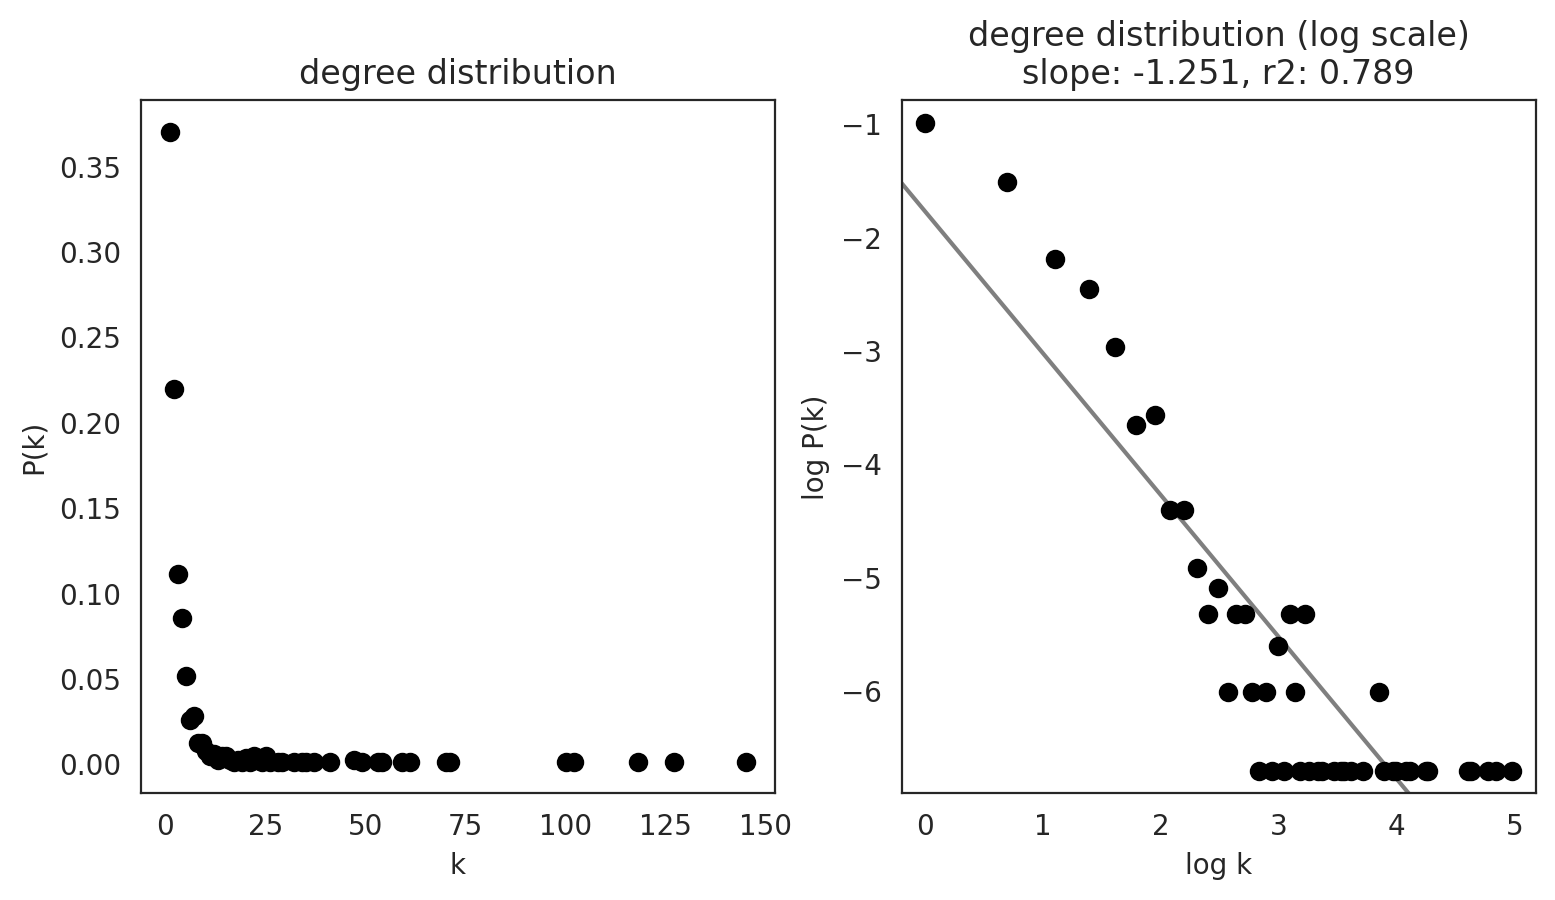

Glutamatergic Cerebellar Nuclei Neurons (Late)


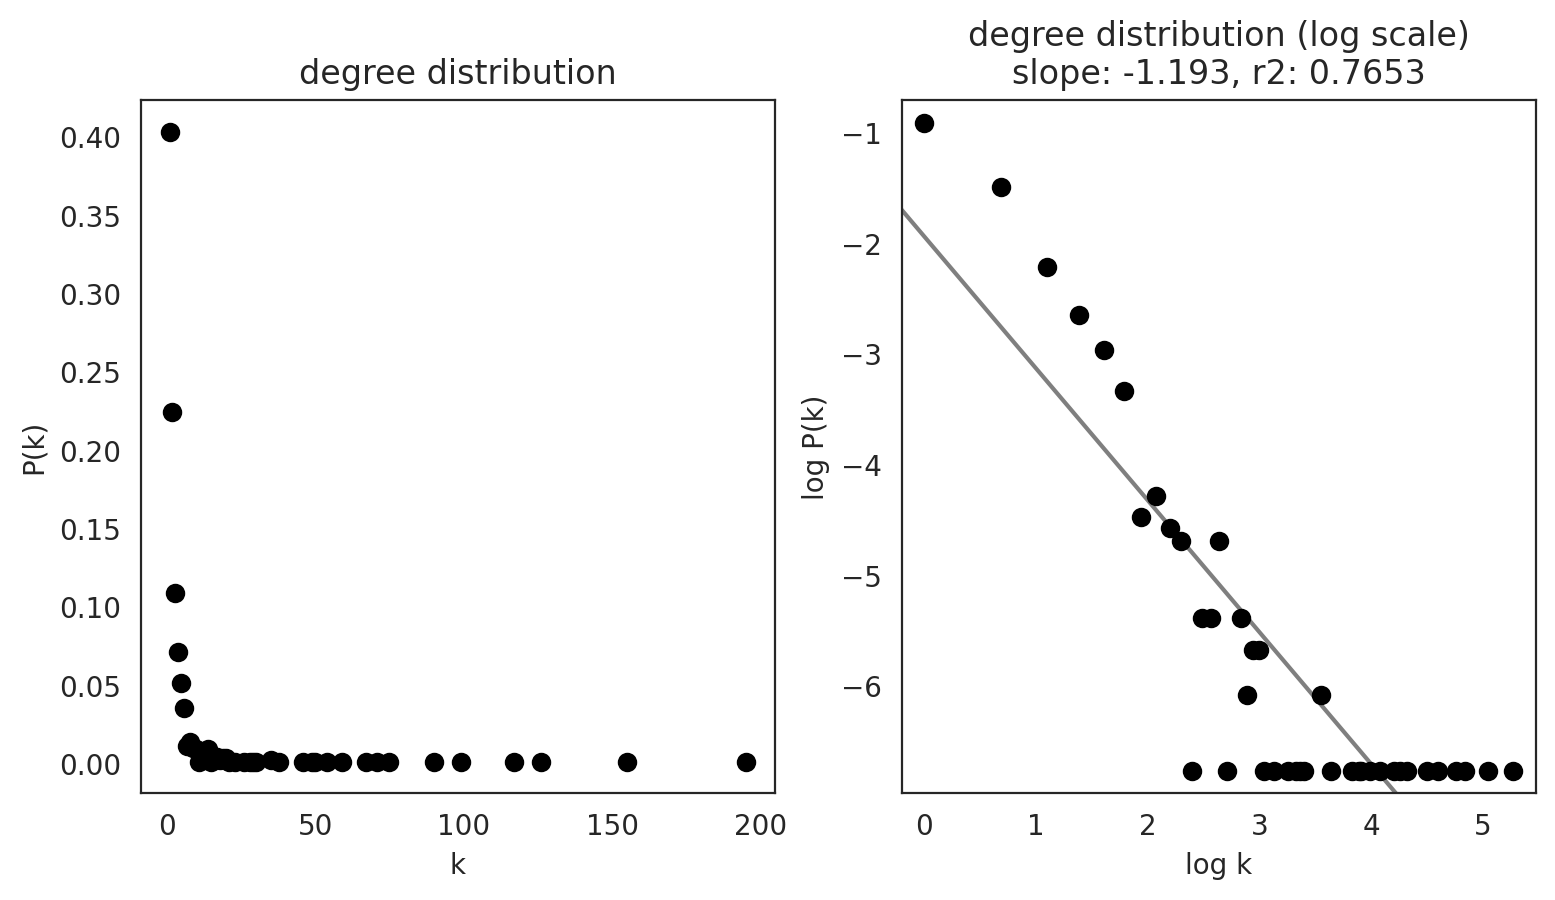

Rhombic Lip Progenitors (Glutamatergic)


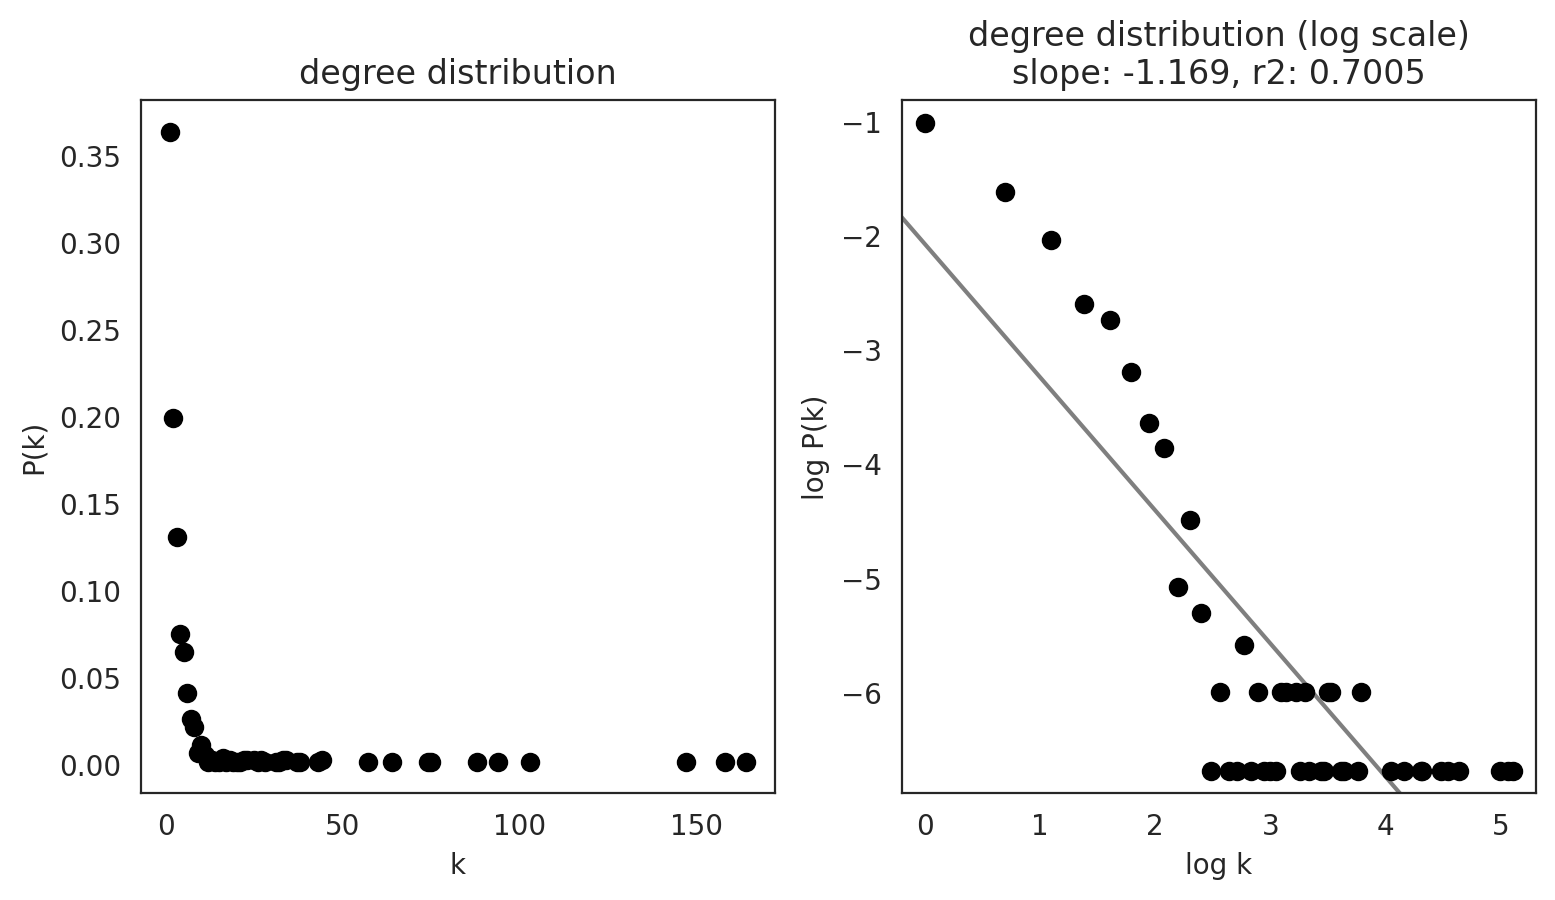

Unipolar Brush Cell Progenitors


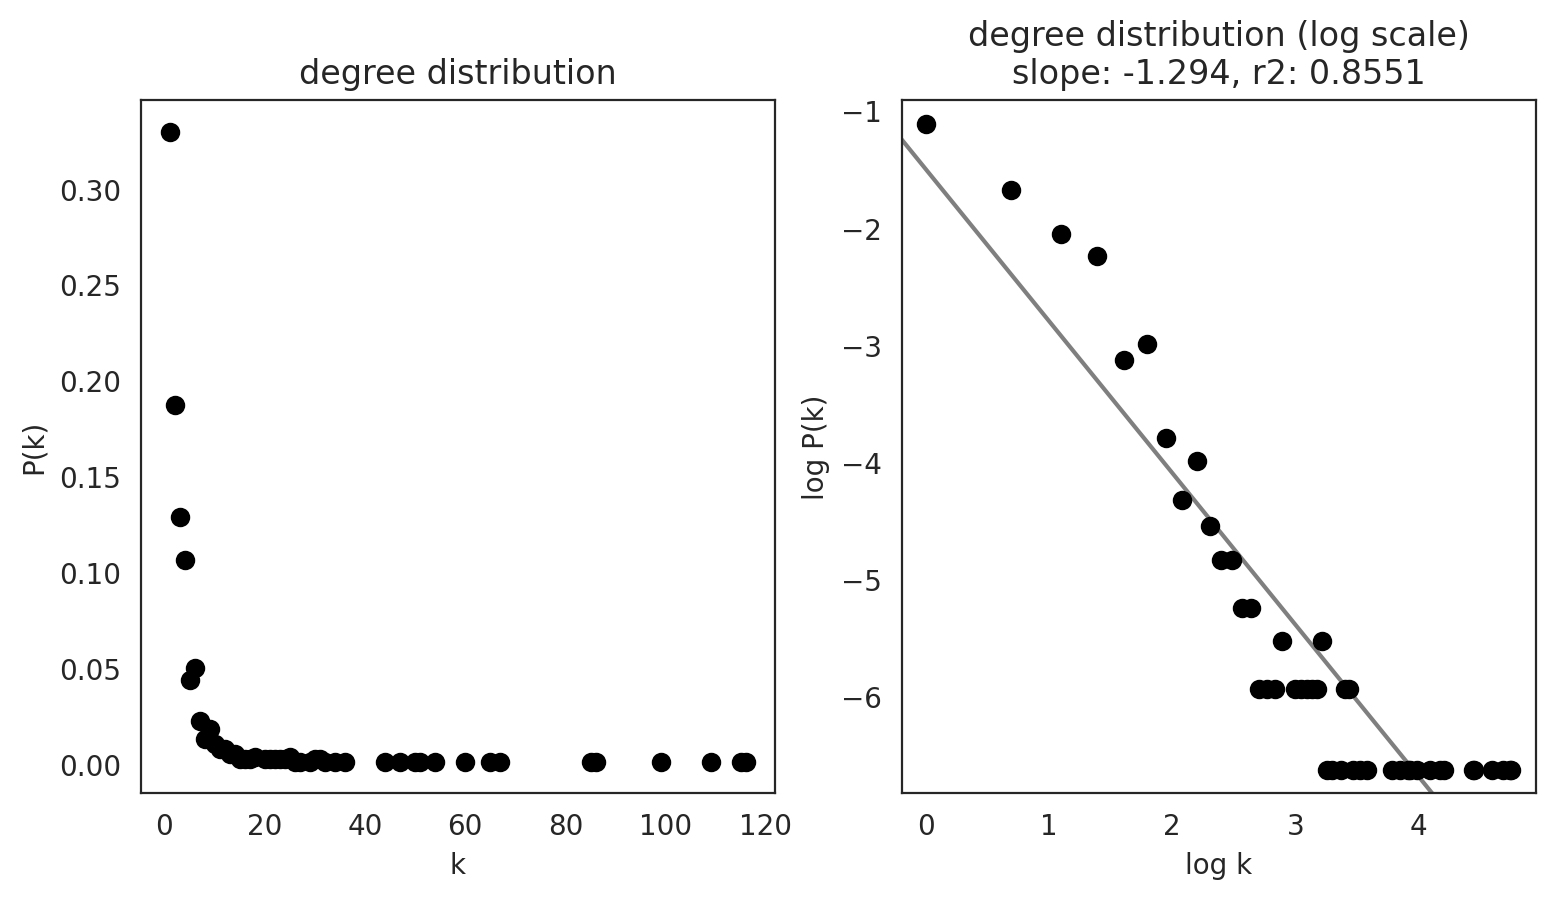

In [39]:
plt.rcParams["figure.figsize"] = [9, 4.5]
links.plot_degree_distributions(plot_model=True, save=f"{save_folder}/degree_distribution/")

In [40]:
plt.rcParams["figure.figsize"] = [6, 4.5]

In [41]:
# Calculate network scores. 
links.get_network_score()

In [42]:
links.merged_score.head() # score is stored as a attribute merged_score.

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
Zic4,145,0.177914,0,0.000000,145,0.177914,0.0,1.000000,Glutamatergic Cerebellar Nuclei Neurons (Early)
Ebf2,8,0.009816,8,0.009816,0,0.000000,0.0,0.257933,Glutamatergic Cerebellar Nuclei Neurons (Early)
Clybl,6,0.007362,6,0.007362,0,0.000000,0.0,0.244916,Glutamatergic Cerebellar Nuclei Neurons (Early)
Atoh1,54,0.066258,2,0.002454,52,0.063804,1364.0,0.240588,Glutamatergic Cerebellar Nuclei Neurons (Early)
Rdh5,3,0.003681,3,0.003681,0,0.000000,0.0,0.047337,Glutamatergic Cerebellar Nuclei Neurons (Early)


Save processed GRNs

In [43]:
# Save Links object.
links.to_hdf5(file_path="./co_output/links_e12_e14_GSE178546.celloracle.links")

In [44]:
# You can load files with the following command.
links = co.load_hdf5(file_path="./co_output/links_e12_e14_GSE178546.celloracle.links")

Network score in each cluster using [centrality metrics](https://en.wikipedia.org/wiki/Centrality), one of the important indicators of network structure. Measures: 
- **betweenness**: effectively counts how many shortest paths each node is on. The higher a node’s betweenness, the more important they are for the efficient flow of goods in a network.
- **degree**: The simplest measure of centrality is degree centrality. It counts how many edges each node has - the most degree central actor is the one with the most ties.
    -  In a directed network, you will need to specify if in or out ties should be counted. These will be referred to as **in** or **out** degree respectively.
- **Eigenvector centrality (Eigencentrality)** measures the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes.

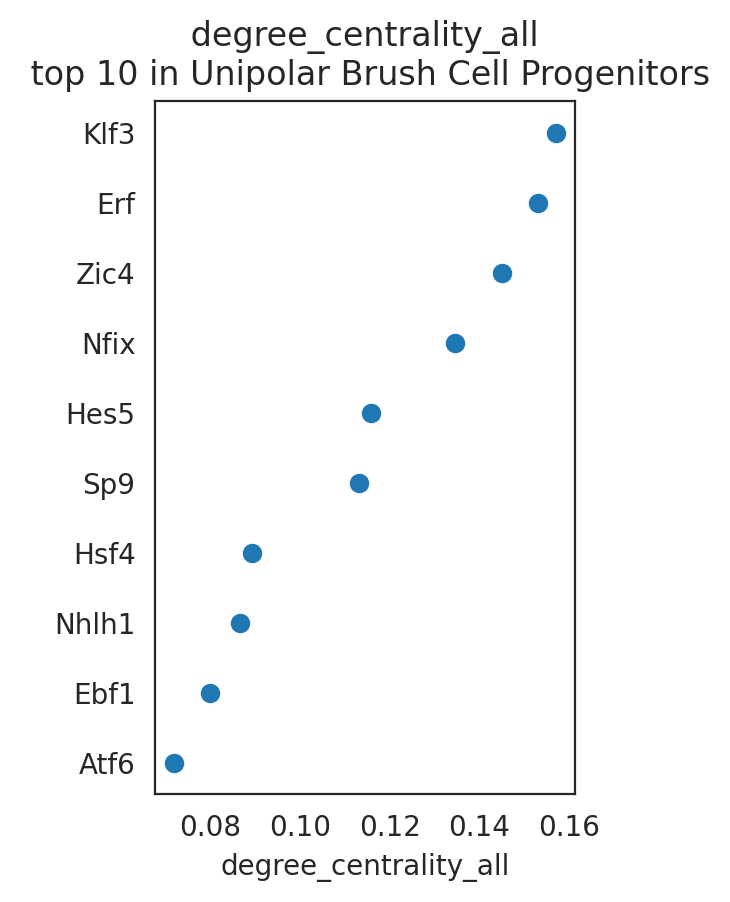

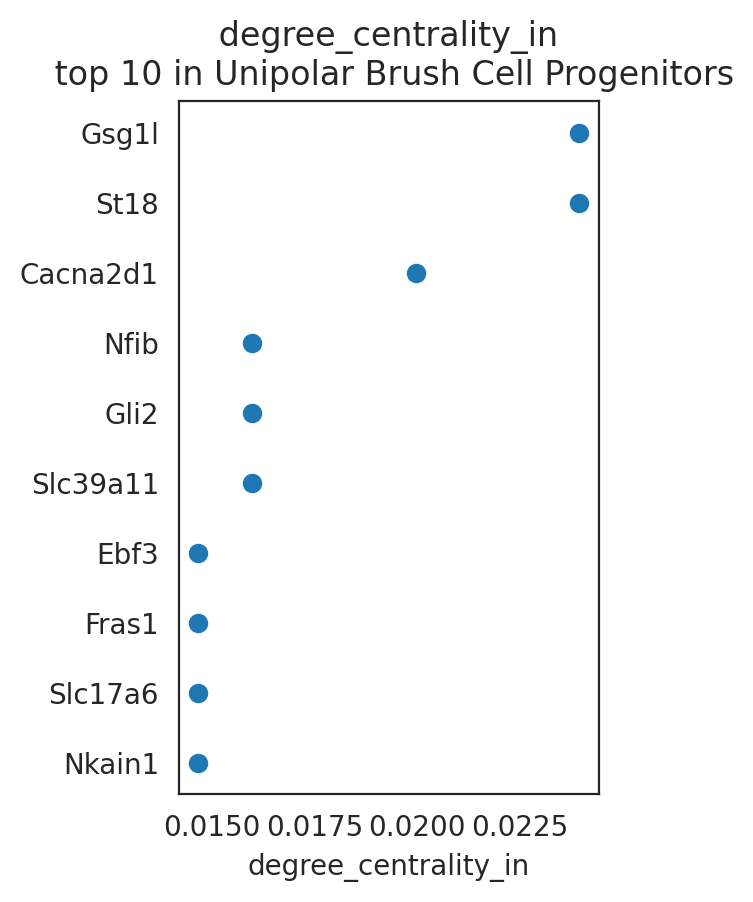

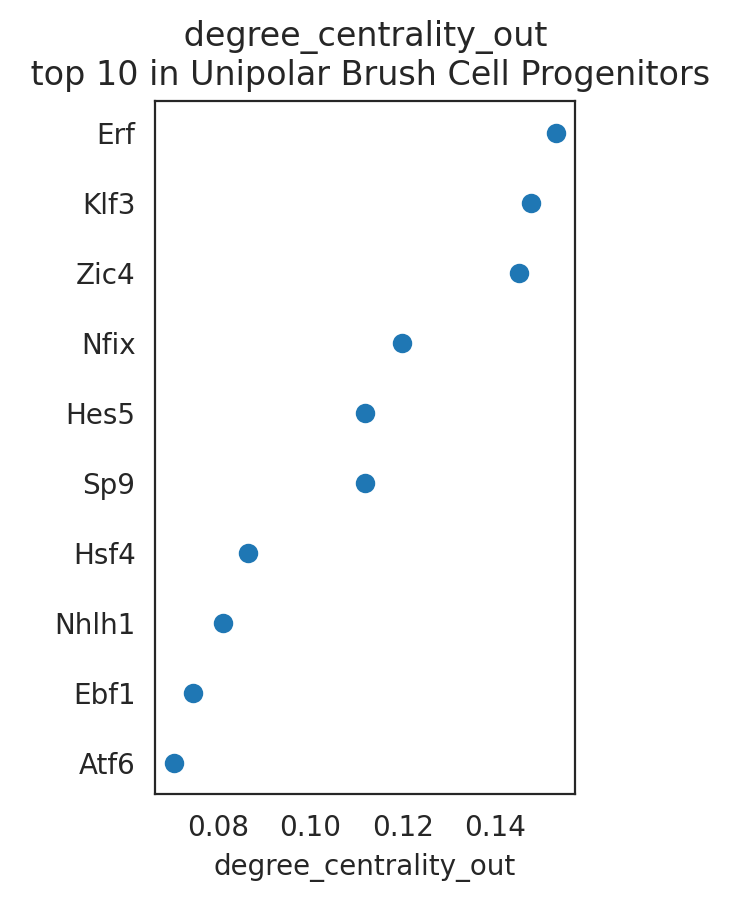

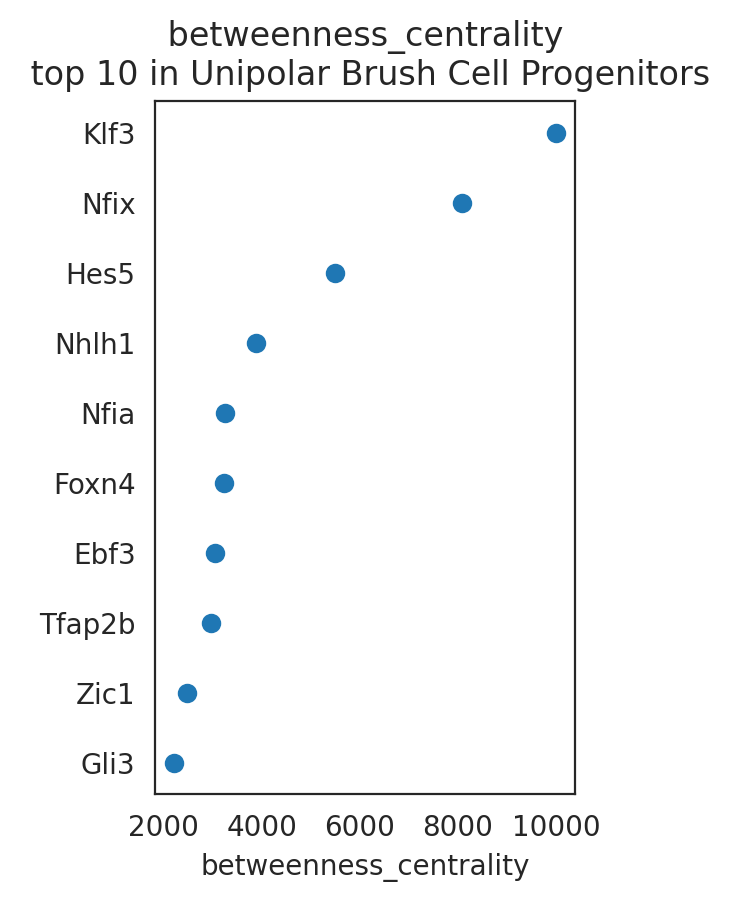

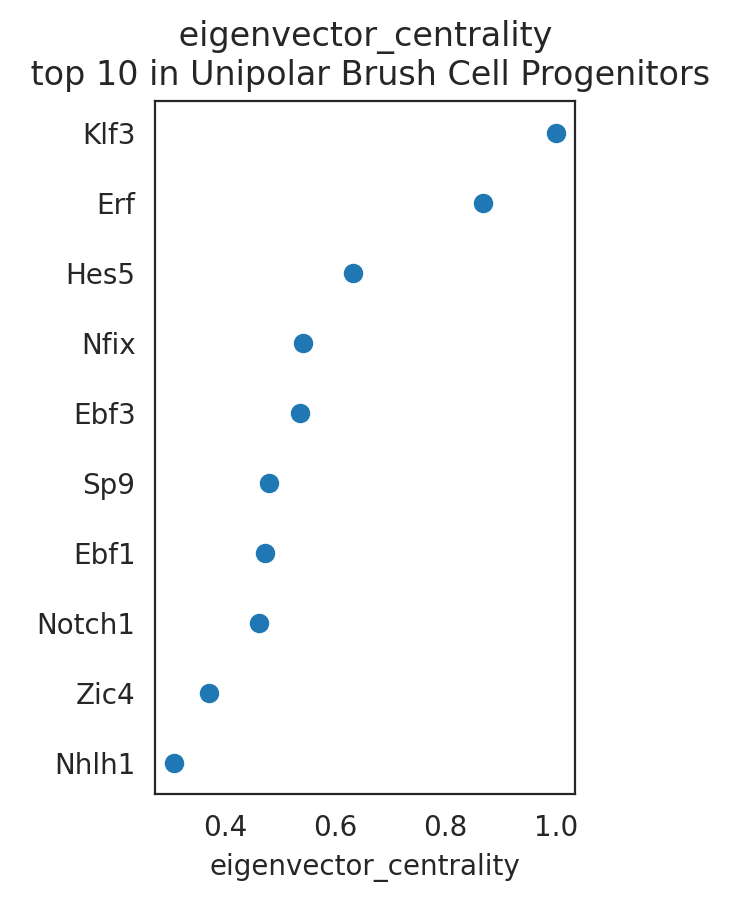

In [61]:
# Visualize top n-th genes with high scores.
# i.e. degree of centrality for top `n_gene` genes for given cluster (UBCs)
# includes 
links.plot_scores_as_rank(cluster="Unipolar Brush Cell Progenitors", n_gene=10, save=f"{save_folder}/ranked_score")

Network score comparison between two clusters
- By comparing network scores between two clusters, we can analyze differences in GRN structure.

In [46]:
links.links_dict.keys()

dict_keys(['Glutamatergic Cerebellar Nuclei Neurons (Early)', 'Glutamatergic Cerebellar Nuclei Neurons (Late)', 'Rhombic Lip Progenitors (Glutamatergic)', 'Unipolar Brush Cell Progenitors'])

MAR 1: CURRENTLY TRYING FOR TOP 99th PERCENTILE + LARGER ANNOT_SHIFTS FOR LEGIBILITY. 

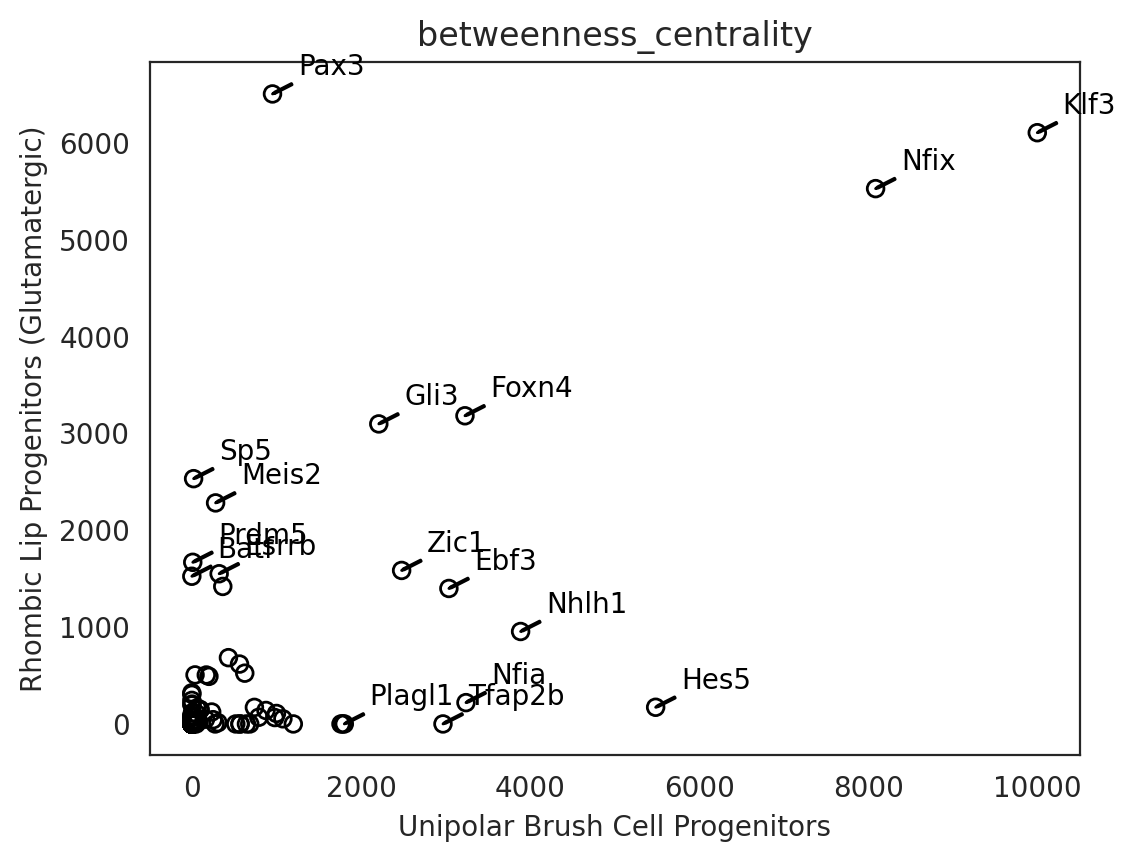

In [60]:
# Compare betweenness_centrality GRN score between two clusters
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="Unipolar Brush Cell Progenitors", cluster2="Rhombic Lip Progenitors (Glutamatergic)", 
                               percentile=99, # default 99
#                                annot_shifts=(-1000, -1000),
                               save=f"{save_folder}/score_comparison")

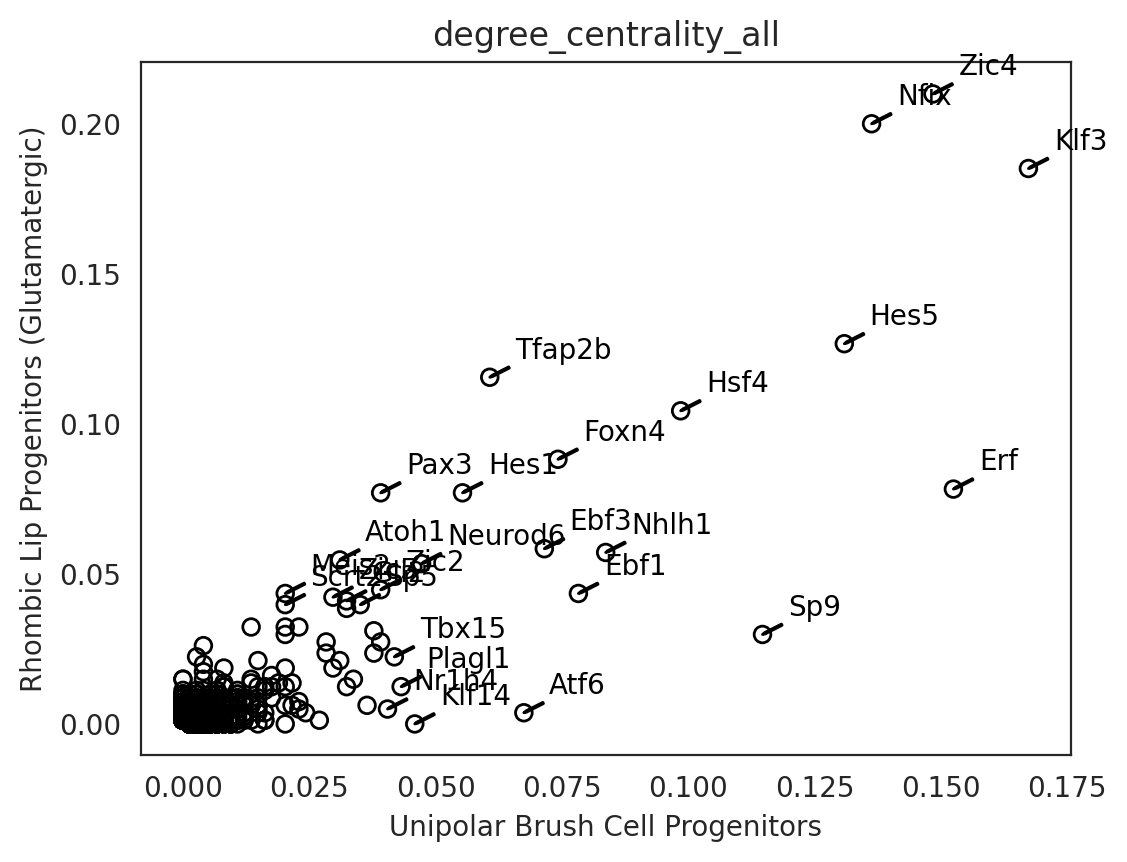

In [38]:
# Compare degree_centrality_all GRN score between two clusters (i.e. in AND out)
links.plot_score_comparison_2D(value="degree_centrality_all",
                               cluster1="Unipolar Brush Cell Progenitors", cluster2="Rhombic Lip Progenitors (Glutamatergic)", 
                               percentile=98, save=f"{save_folder}/score_comparison")

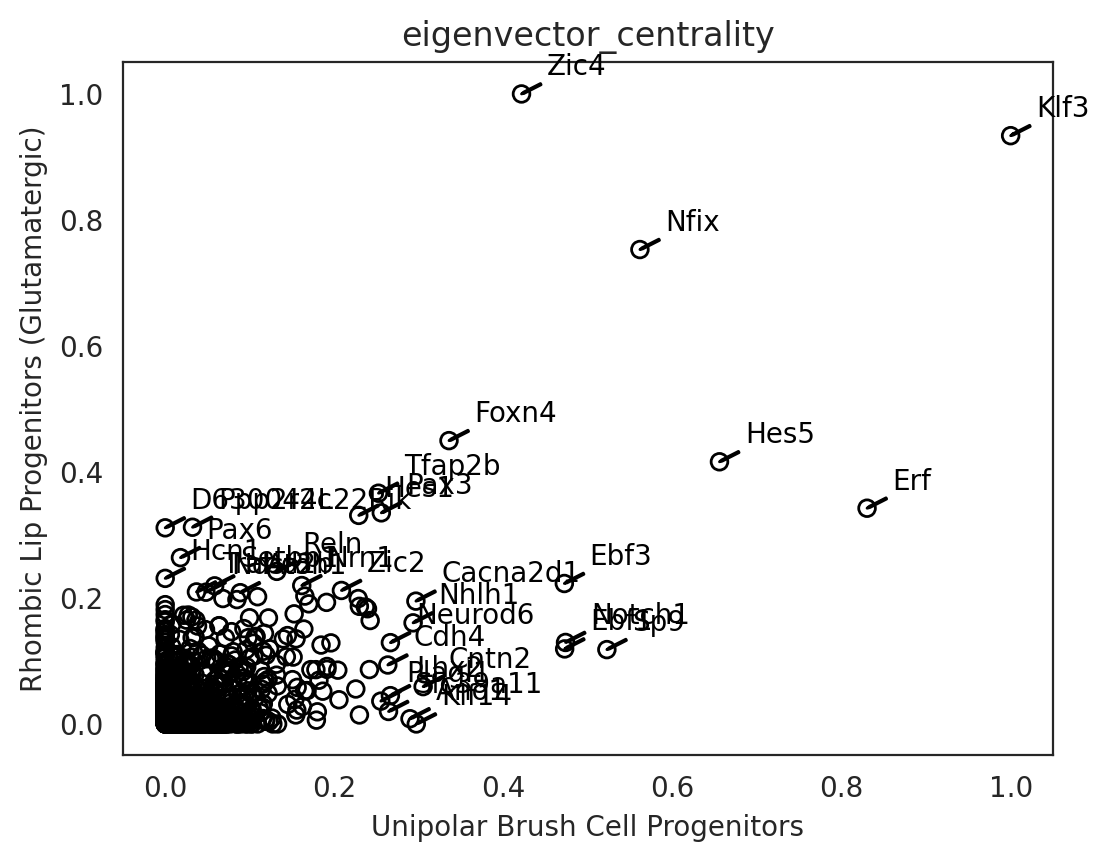

In [39]:
# Compare eigenvector_centrality GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="Unipolar Brush Cell Progenitors", cluster2="Rhombic Lip Progenitors (Glutamatergic)", 
                               percentile=98,
                               save=f"{save_folder}/score_comparison")

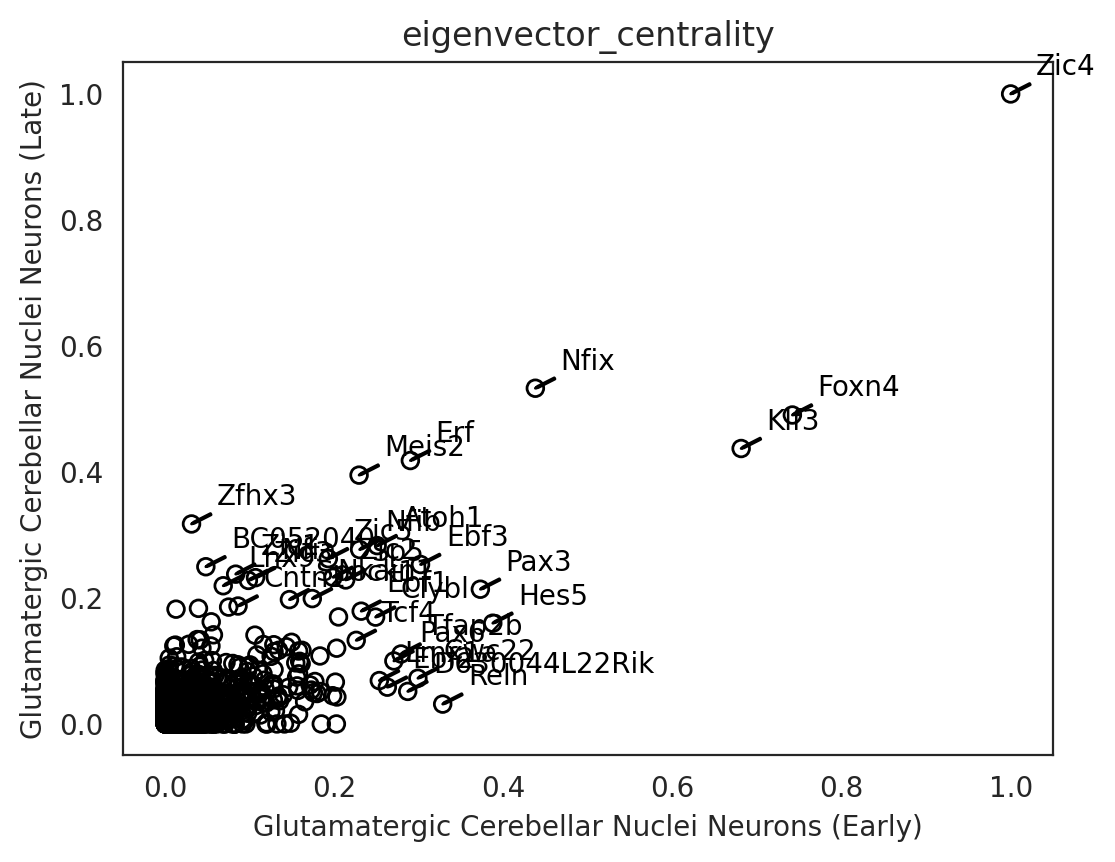

In [41]:
# Compare eigenvector_centrality GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="Glutamatergic Cerebellar Nuclei Neurons (Early)", cluster2="Glutamatergic Cerebellar Nuclei Neurons (Late)", 
                               percentile=98,
                               save=f"{save_folder}/score_comparison")

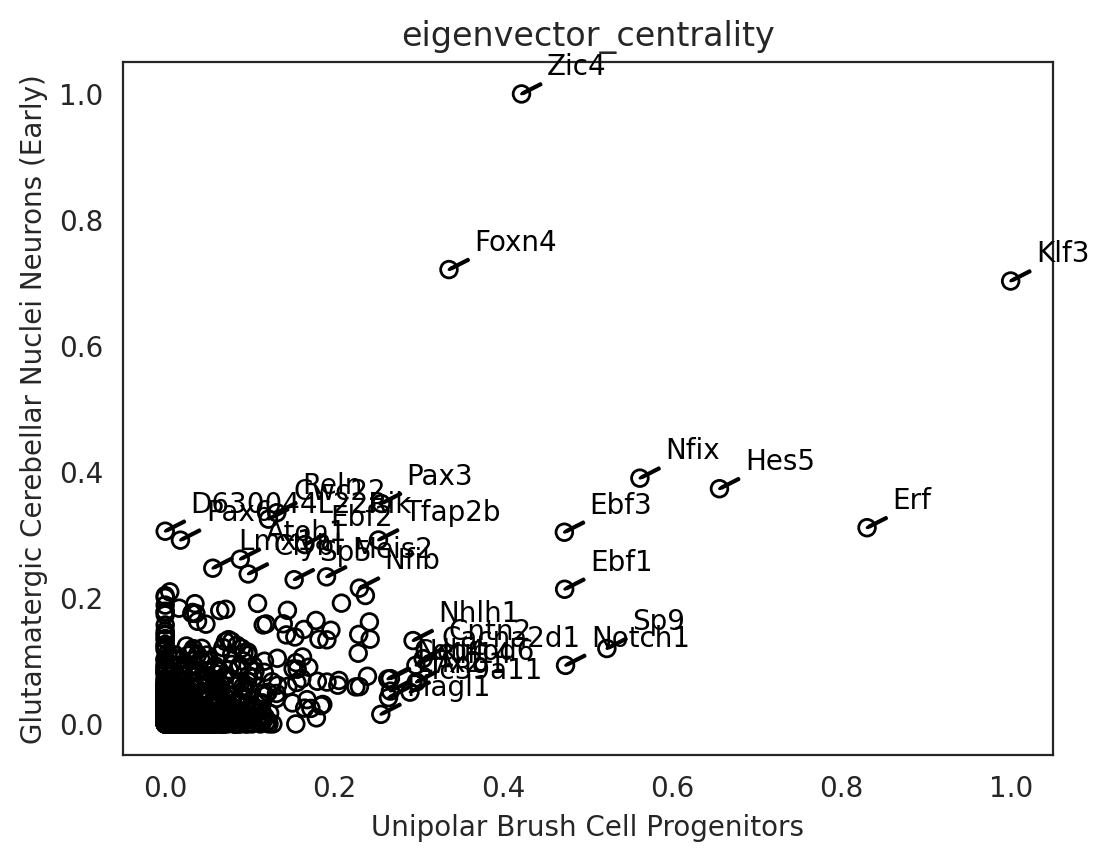

In [40]:
# Compare eigenvector_centrality GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="Unipolar Brush Cell Progenitors", cluster2="Glutamatergic Cerebellar Nuclei Neurons (Early)", 
                               percentile=98,
                               save=f"{save_folder}/score_comparison")

In [41]:
# # Compare eigenvector_centrality GRN score between two clusters
# links.plot_score_comparison_2D(value="eigenvector_centrality",
#                                cluster1="GABAergic Cerebellar Nuclei Neurons", cluster2="Glutamatergic Cerebellar Nuclei Neurons (Late)", 
#                                percentile=98,
#                                save=f"{save_folder}/score_comparison")

7.3. Network score dynamics
- examine chnges in a gene's network score changes during  differentiation.
    - in tutorial: used Gata2 as an example gene because of its role in the early MEP and GMP populations.
- When looking at `filtered_links_df`: 
    - Recall: higher is better for [negative log p value (think volcano plots)](https://www.researchgate.net/figure/Volcano-plot-of-log10-p-values-vs-log2-fold-change-The-log10-p-values_fig1_334891488#:~:text=The%20%2Dlog10%20(p%20values),and%20castration%2Dresistant%20regrowth%20groups.).
    


Pax2


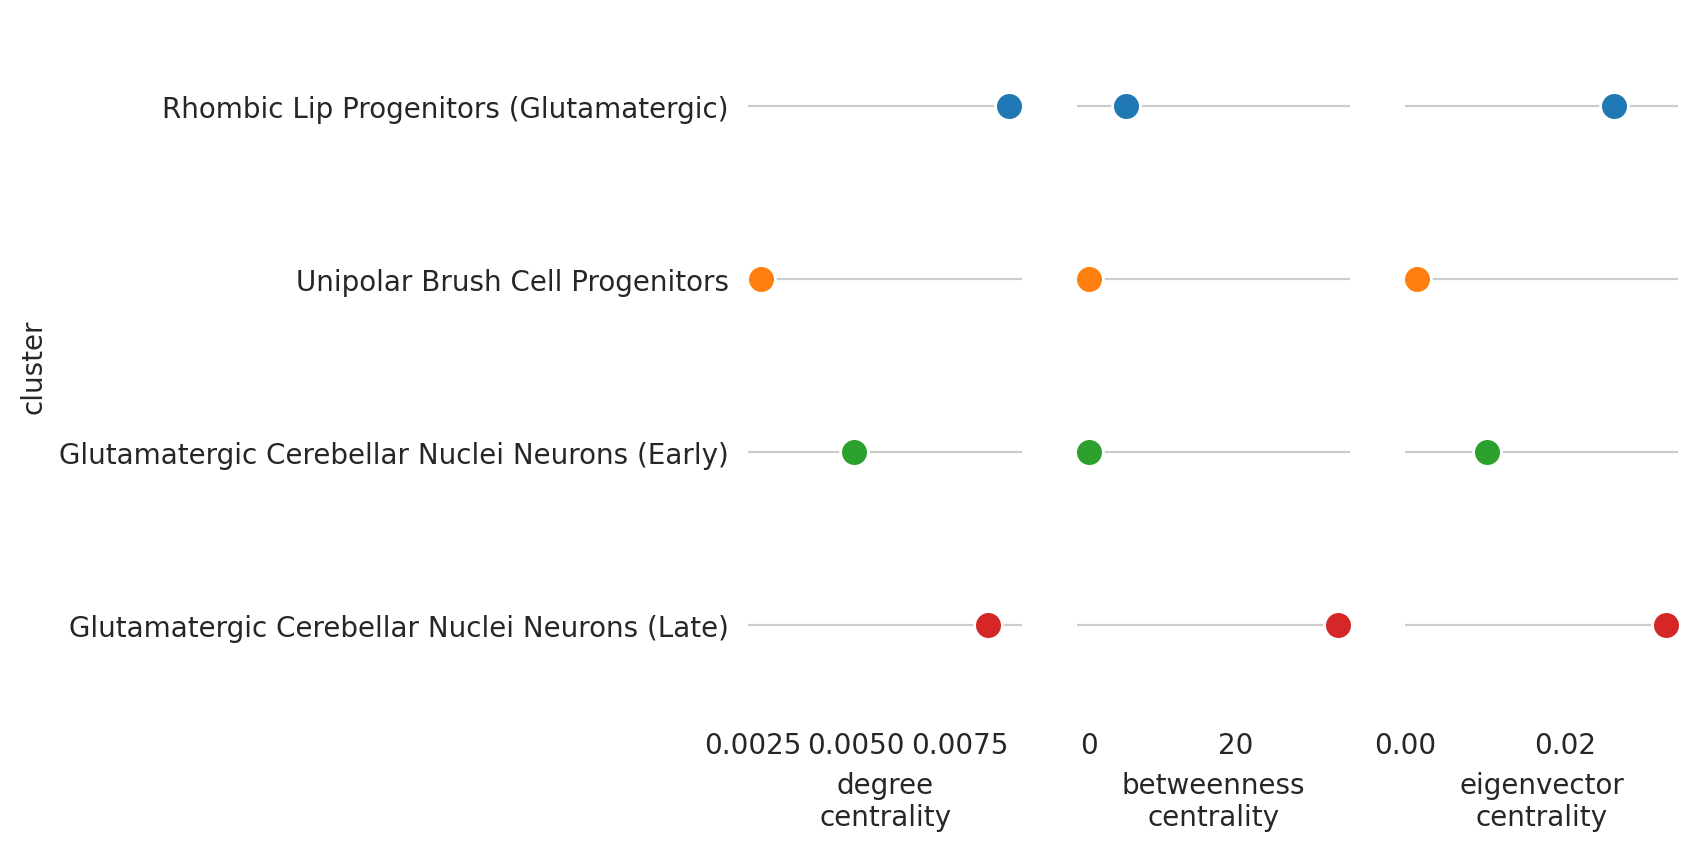

In [42]:
# Visualize Tbr1 network score dynamics
links.plot_score_per_cluster(goi="Pax2", save=f"{save_folder}/network_score_per_gene/")

Pax6


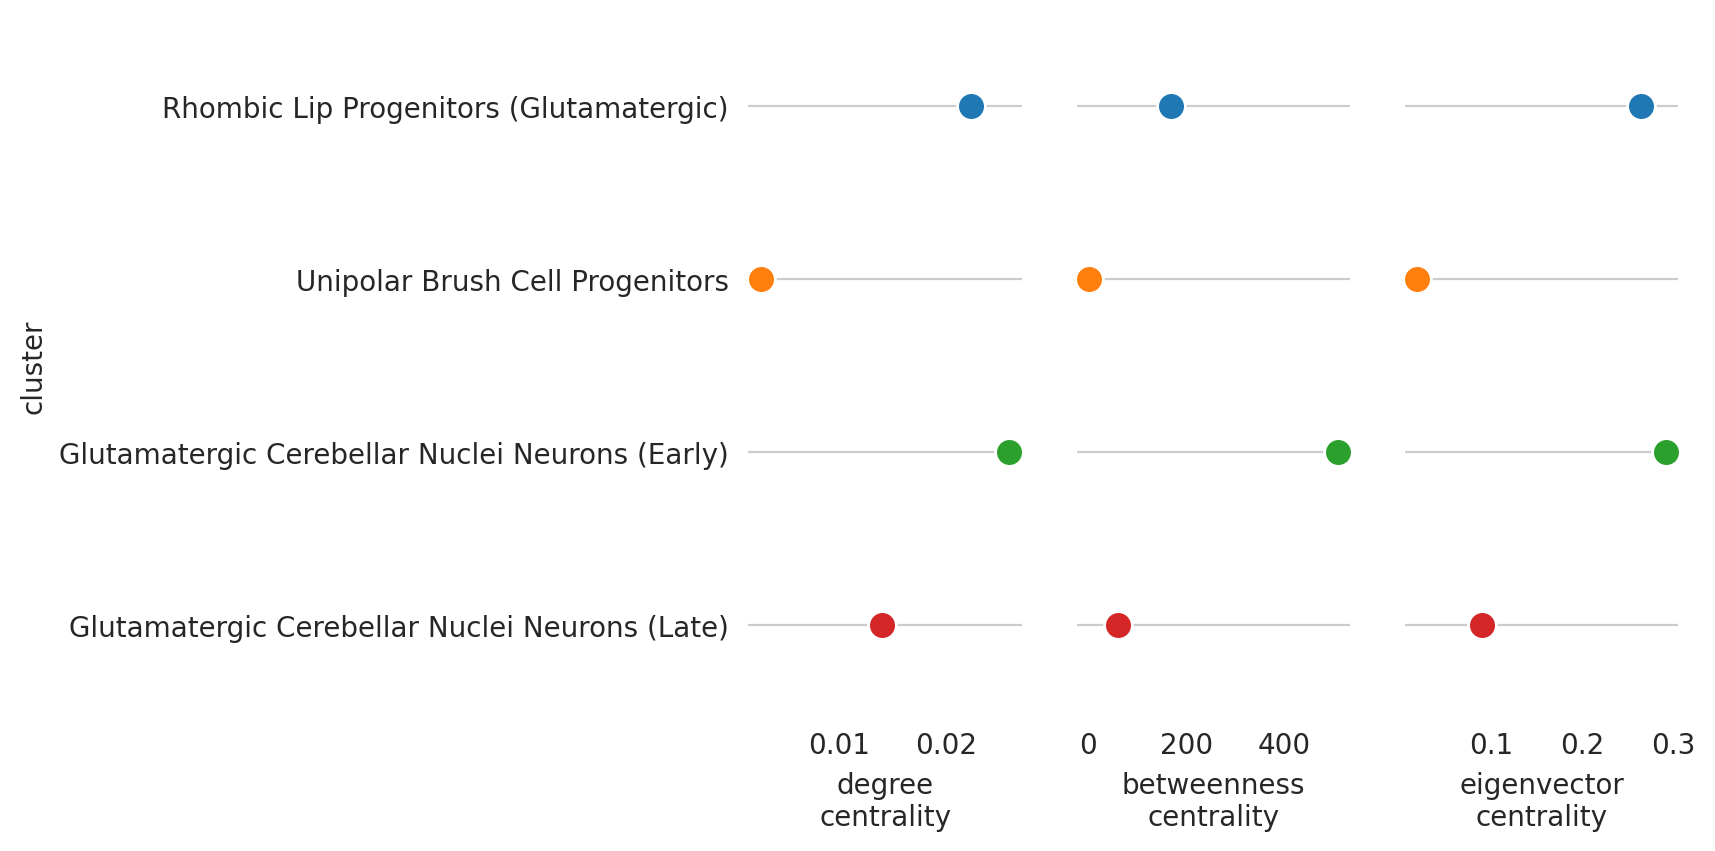

In [43]:
# Visualize Pax6 network score dynamics
links.plot_score_per_cluster(goi="Pax6", save=f"{save_folder}/network_score_per_gene/")

Atoh1


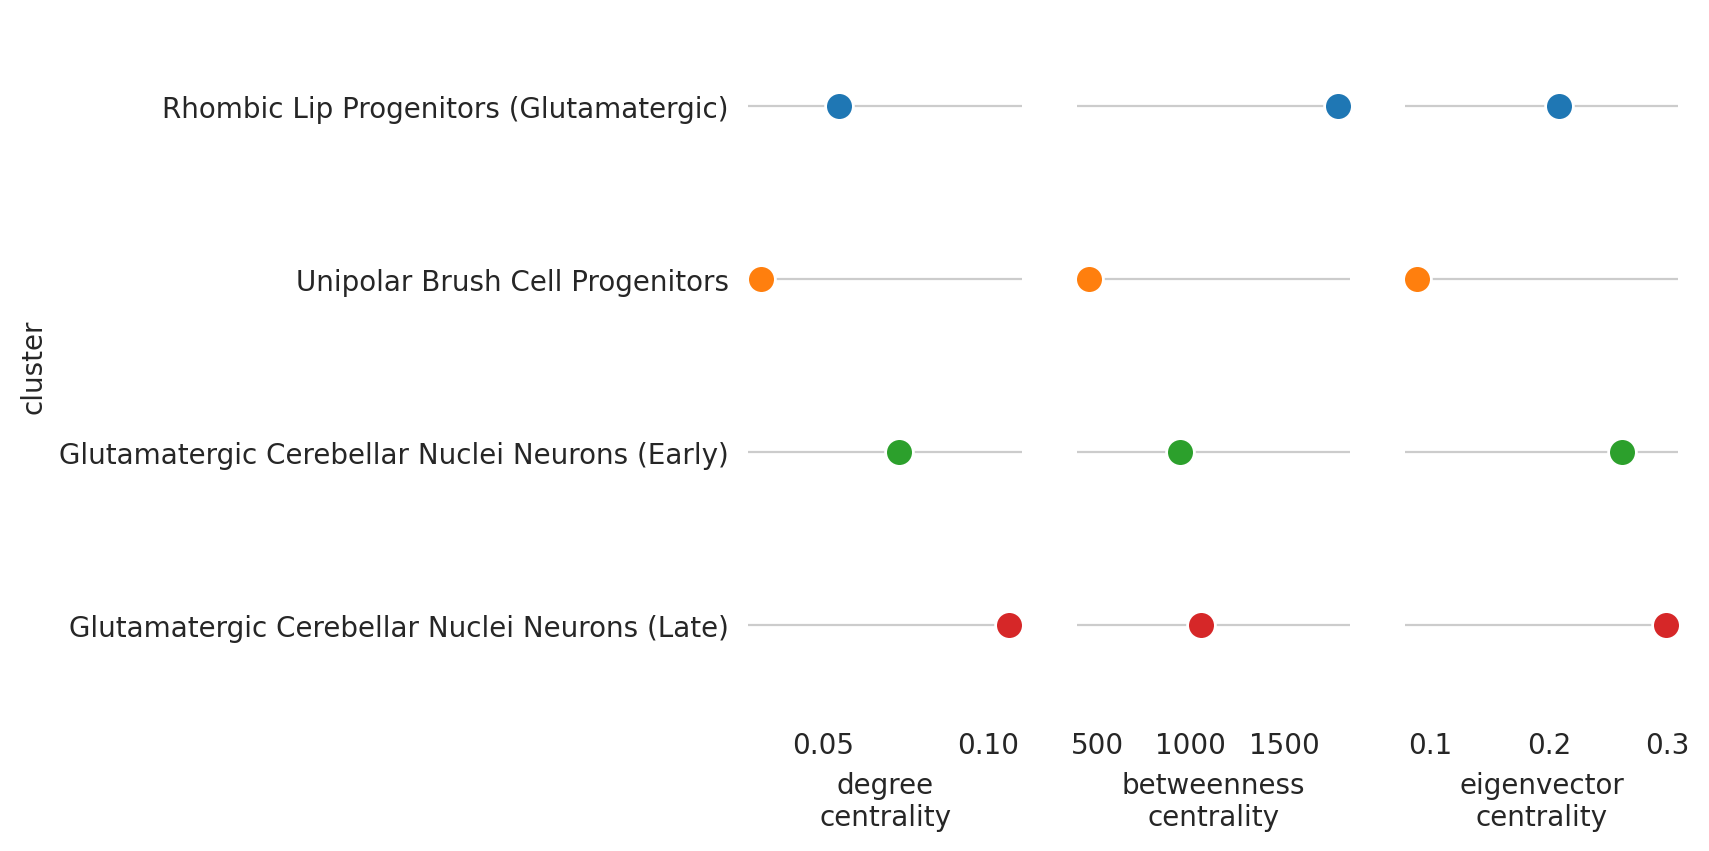

In [44]:
# Visualize Athol1 network score dynamics
links.plot_score_per_cluster(goi="Atoh1")

In [45]:
cluster_name = "Unipolar Brush Cell Progenitors" 
filtered_links_df = links.filtered_links[cluster_name]
filtered_links_df.head()

,source,target,coef_mean,coef_abs,p,-logp
24861,Klf3,Notch1,0.216339,0.216339,1.747760e-17,16.757518
18157,Sp5,Jakmip1,-0.127808,0.127808,2.127503e-23,22.672130
7170,Neurod6,Cntn2,0.118709,0.118709,1.498530e-13,12.824335
6740,Neurod6,Clnk,0.116967,0.116967,3.555242e-19,18.449131
6811,Zic4,Clybl,0.113431,0.113431,1.043316e-13,12.981584


In [46]:
filtered_links_df[filtered_links_df.source == "Pax2"]

,source,target,coef_mean,coef_abs,p,-logp
28592,Pax2,Ppfia4,0.028306,0.028306,1.882432e-08,7.725281
37922,Pax2,Tmem178,0.025899,0.025899,1.032610e-10,9.986064


# Network score distribution: global network trends insight.

degree_centrality_all


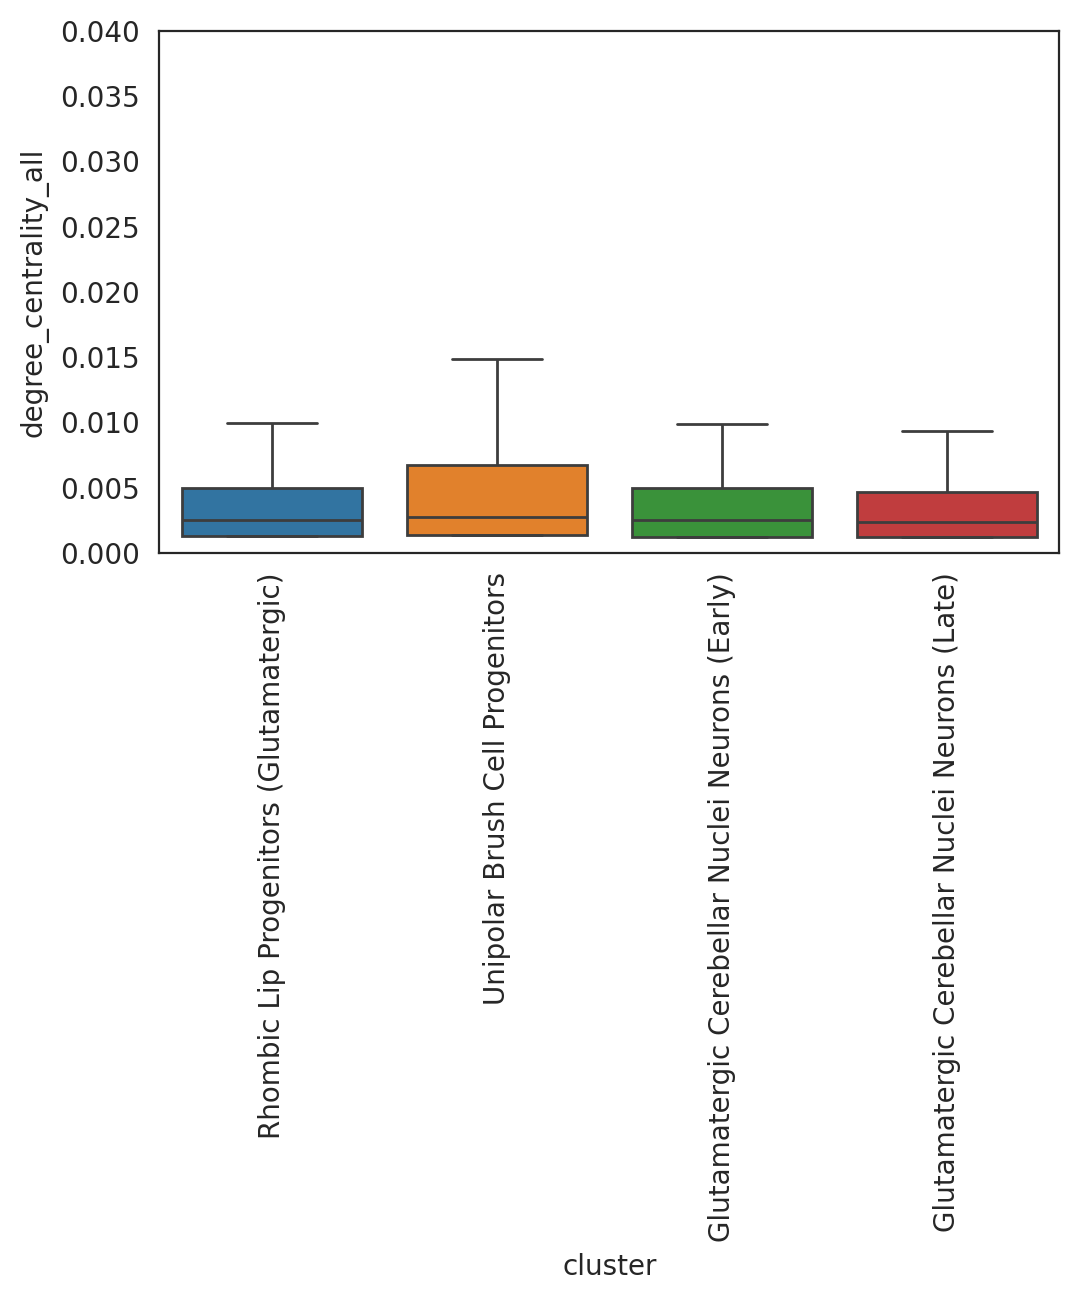

In [47]:
# Distribution of network degree
plt.rcParams["figure.figsize"] = [6, 4.5]
# Plot degree_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.040])
links.plot_score_discributions(values=["degree_centrality_all"], 
                               method="boxplot", 
                               save=f"{save_folder}",
                              )

eigenvector_centrality


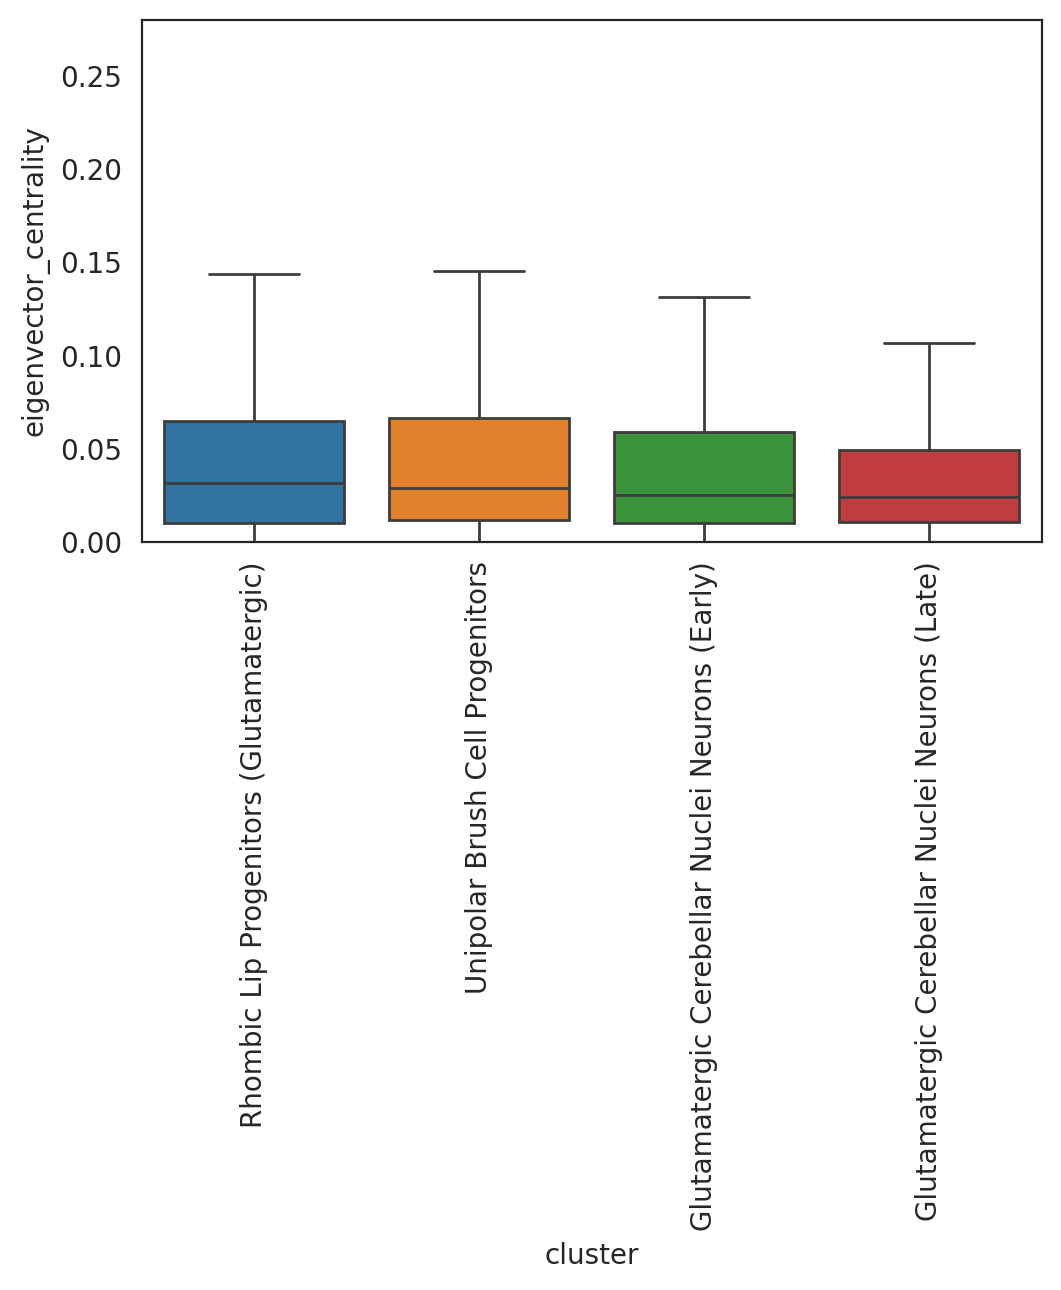

In [48]:
# Plot eigenvector_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0, 0.28])
links.plot_score_discributions(values=["eigenvector_centrality"],
                               method="boxplot",
                               save=f"{save_folder}")

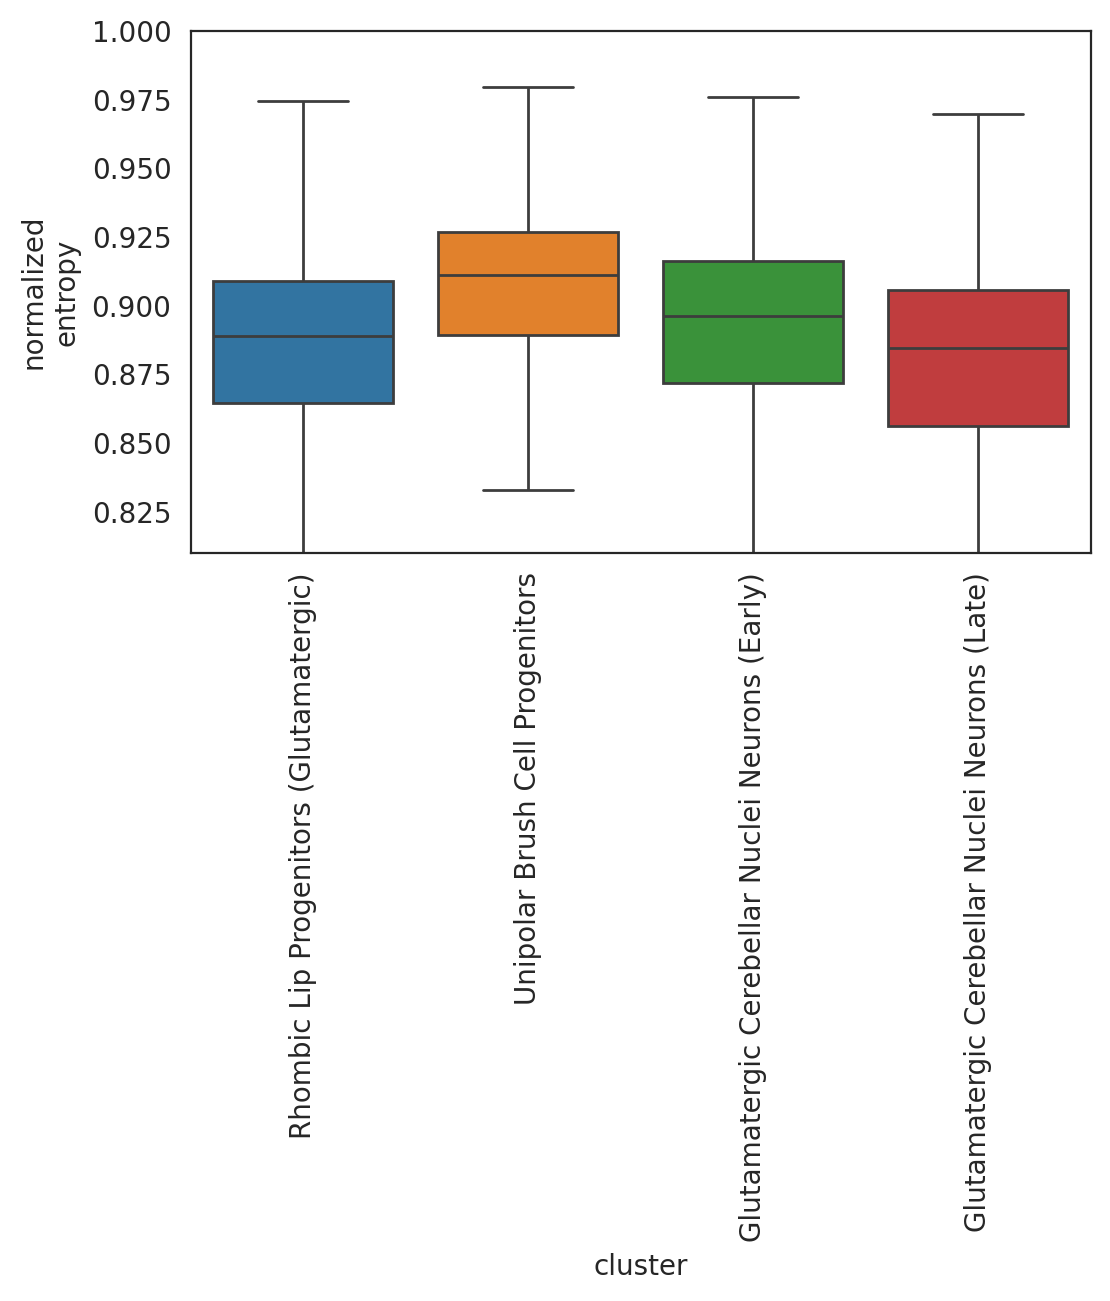

In [49]:
# Distribution of network entropy
plt.subplots_adjust(left=0.15, bottom=0.3)
links.plot_network_entropy_distributions(save=f"{save_folder}")